In [38]:
import pandas as pd
import numpy as np
import re
import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import hamming_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import train_test_split as sk_split
import matplotlib.pyplot as plt
%matplotlib inline 

# Milestone 3: Traditional statistical and machine learning methods, due Wednesday, April 19, 2017

Think about how you would address the genre prediction problem with traditional statistical or machine learning methods. This includes everything you learned about modeling in this course before the deep learning part. Implement your ideas and compare different classifiers. Report your results and discuss what challenges you faced and how you overcame them. What works and what does not? If there are parts that do not work as expected, make sure to discuss briefly what you think is the cause and how you would address this if you would have more time and resources. 

You do not necessarily need to use the movie posters for this step, but even without a background in computer vision, there are very simple features you can extract from the posters to help guide a traditional machine learning model. Think about the PCA lecture for example, or how to use clustering to extract color information. In addition to considering the movie posters it would be worthwhile to have a look at the metadata that IMDb provides. 

You could use Spark and the [ML library](https://spark.apache.org/docs/latest/ml-features.html#word2vec) to build your model features from the data. This may be especially beneficial if you use additional data, e.g., in text form.

You also need to think about how you are going to evaluate your classifier. Which metrics or scores will you report to show how good the performance is?

The notebook to submit this week should at least include:

- Detailed description and implementation of two different models
- Description of your performance metrics
- Careful performance evaluations for both models
- Visualizations of the metrics for performance evaluation
- Discussion of the differences between the models, their strengths, weaknesses, etc. 
- Discussion of the performances you achieved, and how you might be able to improve them in the future

#### Preliminary Peer Assessment

It is important to provide positive feedback to people who truly worked hard for the good of the team and to also make suggestions to those you perceived not to be working as effectively on team tasks. We ask you to provide an honest assessment of the contributions of the members of your team, including yourself. The feedback you provide should reflect your judgment of each team member’s:

- Preparation – were they prepared during team meetings?
- Contribution – did they contribute productively to the team discussion and work?
- Respect for others’ ideas – did they encourage others to contribute their ideas?
- Flexibility – were they flexible when disagreements occurred?

Your teammate’s assessment of your contributions and the accuracy of your self-assessment will be considered as part of your overall project score.

Preliminary Peer Assessment: [https://goo.gl/forms/WOYC7pwRCSU0yV3l1](https://goo.gl/forms/WOYC7pwRCSU0yV3l1)

## Questions to answer: 

- **What are we predicting exactly?**

So, we are trying to predict movie genres. However, we have that each movie has multiple genres. This leads to the question of how we can predict multiple classifiers for the same object. This more general question is called a multilabel clasification problem. We will explore some of our specifications for this problem below. 

One of the best and most standard solution to do multilable classification is called "one vs. rest" classifiers. These classifiers create n models for each of the n labels. One of the advantages of this model is its interpretability and, for our cases, its ease. We can easily create a pipeline that then does these predictions for us. For an implementation of one vs. all, look at scikit learn: http://scikit-learn.org/dev/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier

We will likely be using this in our early attempts at classification. 

- **What does it means to be succesful? What is our metric for success?**

*adapted from http://people.oregonstate.edu/~sorowerm/pdf/Qual-Multilabel-Shahed-CompleteVersion.pdf*

Here are a few options for our measure of accuracy:

#### Exact Match Ratio
The exact match ratio only considers a correct answer for our multilabel data if it is exactly correct (e.g. if there are three classes, we only classify this as correct if we correctly identify all three classes.) 

#### Accuracy 
Accuracy is a simple way of "goodness of prediction." It is defined as follows 

$$ \frac{1}{n} \sum_i^{n}  \frac{|Y_i\cap Z_i|}{|Y_i \cup Z_i|}$$

Where $$Y_i\cap Z_i $$ refers to the total number of correctly predicted labels over the total number of labels for that instance. So, if for example we predicted [romance, action]  and the true labels were [romance, comedy, horror], this would receive an accuracy of 1/4 because there was one correct prediction and 4 unique labels. 

# Our Prediction Metric 


#### Hamming Loss 
The final and most common form of error for multilable predictions is hamming loss. Hamming loss takes into account both the prediction error (an incorrect error is predicted) and the missing error (a relevant lable is NOT predicted.) this is defined as follows below 

$$ \text{HammingLoss, HL} = \frac{1}{kn} \sum_{i}^{n} \sum_l^k [l \in  Z_i \wedge l \notin Y_i)  + I(l \notin Z_i \wedge  l \in Y_i)]$$

*For this project, we will use the hamming loss, which is defined above.* There is a convenient function in `sklearn` to calculate hamming loss: `sklearn.metrics.hamming_loss`

- What is our first modeling approach? Why? 

- What is our second modeling approach? Why? 

In [11]:
'''
An example of hamming loss. We have true labels:

[0, 1]
[1, 1]

And predicted labels:

[0, 0]
[0, 0]

Hamming loss is .75
'''
hamming_loss(np.array([[0, 1], [1, 1]]), np.zeros((2, 2)))

0.75

# Our Approach: Two Main Models: 
For our approach, we use two main models a random forest and an SVM.  IN particular, we decided to focus on 10 main predictos about the movies (from who directed, the rating, and popularity) to an analysis of the textual response in the overview. However, before we could use our textual data for prediction we changed our textual response to become a count vectorizer 

# Going from text to countvectorizer 
For all of our models, we changed our overview to become a count vectorizer. A count vectorizer takes all of the words that from all of the different overviews and then makes a column for each unique word. Then we create a matrix called a document word matrix. This matrix holds the number of times each unique word is discovered in the document. This allows us to then make predictions from there. 

### Data Collection & Cleaning

## Decision for dropping
Here we choose to drop the missing data instead of imputing because it is non numerical and avereraging or finding means does not make sense in this scencario

In [2]:
#train = pd.read_csv("../data/train_full.csv")
train = pd.read_csv("train_full.csv")

train = train.rename(columns={'lead actors': 'actors'})

# drop a rogue column
train.drop("Unnamed: 0", axis = 1, inplace = True)
train = train.dropna(axis=0).copy()
print "Dataframe shape:", train.shape
train.head(1)

Dataframe shape: (7143, 32)


,10402,10749,10751,10752,10769,10770,12,14,16,18,...,actors,movie_id,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,0,0,0,0,0,0,0,0,0,1,...,"[u'Amy Adams', u'Jeremy Renner', u'Forest Whit...",329865,Taking place after alien crafts land around th...,25.66195,/hLudzvGfpi6JlwUnsNhXwKKg4j.jpg,2016-11-10,Arrival,False,6.9,3510


In [3]:
# check for null values
train.isnull().any()

10402           False
10749           False
10751           False
10752           False
10769           False
10770           False
12              False
14              False
16              False
18              False
27              False
28              False
35              False
36              False
37              False
53              False
80              False
878             False
9648            False
99              False
adult           False
director        False
actors          False
movie_id        False
overview        False
popularity      False
poster_path     False
release_date    False
title           False
video           False
vote_average    False
vote_count      False
dtype: bool

# Model 1: Random Forest

Some thoughts:
    * Random forests don't accept strings, so we'll need to vectorize all of the string variables or exclude them entirely. 

In [4]:
train.columns

Index([u'10402', u'10749', u'10751', u'10752', u'10769', u'10770', u'12',
       u'14', u'16', u'18', u'27', u'28', u'35', u'36', u'37', u'53', u'80',
       u'878', u'9648', u'99', u'adult', u'director', u'actors', u'movie_id',
       u'overview', u'popularity', u'poster_path', u'release_date', u'title',
       u'video', u'vote_average', u'vote_count'],
      dtype='object')

In [5]:
# dummify string columns: director
dummies_directors = train.director.astype(str).str.strip('[]').str.get_dummies(', ')

In [6]:
dummies_directors.shape

(7143, 2349)

In [7]:
# number of times directors show in the data more than once
for col in dummies_directors.columns:
    if sum(dummies_directors[col]) > 1:
        print col, sum(dummies_directors[col])

 Yeon Sang-Ho 3
Aaron Blaise 3
Aaron Woodley 2
Adam Green 2
Adam McKay 6
Adam Randall 4
Adam Robitel 2
Adam Shankman 11
Adam Wingard 6
Adrian Lyne 2
Adrian Maben 2
Afonso Poyart 3
Aisling Walsh 2
Akira Kurosawa 7
Akiva Goldsman 3
Akiva Schaffer 2
Alain Chabat 4
Alain Resnais 4
Alan Barillaro 2
Alan J. Pakula 4
Alan Myerson 2
Alan Parker 5
Alan Taylor 7
Alastair Fothergill 4
Albert Hughes 6
Alejandro Amenábar 5
Alejandro González Iñárritu 8
Aleksander Bach 3
Alex Garland 2
Alex Gibney 5
Alex Kurtzman 2
Alex Proyas 10
Alex Turner 2
Alex Winter 2
Alex Zamm 2
Alexander Payne 4
Alexander Witt 2
Alexandre Aja 7
Alexandre Astier 3
Alfonso Cuarón 11
Alfred Hitchcock 22
Alfred Vohrer 2
Amy Heckerling 7
Anand Tucker 2
Anatole Litvak 3
Andrea Arnold 2
Andrei Tarkovsky 6
Andrew Adamson 17
Andrew Davis 4
Andrew Dominik 2
Andrew Knight 2
Andrew Niccol 10
Andrew Stanton 11
Andrew V. McLaglen 8
André Øvredal 2
Andy Fickman 5
Andy Muschietti 2
Andy Tennant 4
Andy de Emmony 2
Ang Lee 11
Angelina Jolie 2

In [8]:
# dummify string columns: lead actors
dummies_actors = train.actors.astype(str).str.strip('[]').str.get_dummies(', ') 

In [9]:
dummies_actors.shape

(7143, 6059)

In [91]:
# number of times directors show in the data more than once
# for col in dummies_actors.columns:
#     if sum(dummies_actors[col]) > 1:
#         print col, sum(dummies_actors[col])

In [10]:
colnames = list(train.columns) + list(dummies_directors.columns) + list(dummies_actors.columns)
combined_df = pd.DataFrame(pd.concat([train, dummies_directors, dummies_actors], axis = 1),
                      columns = colnames)

#combined_df.drop(combined_df.index[0])
combined_df.shape

(7143, 8440)

In [11]:
# drop actors and directors columns
combined_df = combined_df.drop('actors', 1)
combined_df = combined_df.drop('director', 1)

# drop overview and titles
combined_df = combined_df.drop('title', 1)
combined_df = combined_df.drop('overview', 1)
combined_df = combined_df.drop('poster_path', 1)
combined_df = combined_df.drop('release_date', 1)


combined_df.head()

,10402,10749,10751,10752,10769,10770,12,14,16,18,...,u'Zoe Sloane',u'Zoey Deutch',u'Zofia Wich\u0142acz',u'Zooey Deschanel',u'Zsa Zsa G\xe1bor',u'Zuleikha Robinson',u'\u0110\u1ed7 Th\u1ecb H\u1ea3i Y\u1ebfn',u'\u5188\u672c\u4fe1\u5f66',u'\xc9milie Dequenne',u'\xd3scar Jaenada'
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
string_cols = ["director", "actors", "overview", "title"]

string_matrix = train[string_cols]

In [13]:
# trim trailing and leading spaces
string_matrix = string_matrix.apply(lambda col: col.str.strip())

In [14]:
# Set up helper cleaner function
def cleaner(cell):
    line = cell.replace('[u', '').replace(']', '').replace(',', '').replace("u'", '').replace("'", '')
    line = re.sub("(^|\W)\d+($|\W)", " ", line)
#     line.encode('utf-8').strip()
    return line
string_matrix['actors'] = string_matrix['actors'].apply(cleaner)
string_matrix['overview'] = string_matrix['overview'].apply(cleaner)
string_matrix['actors'] = string_matrix['actors'].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
string_matrix['overview'] = string_matrix['overview'].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))

In [15]:
# def _coo_to_sparse_series(A, dense_index=False):
#     """ Convert a scipy.sparse.coo_matrix to a SparseSeries.
#     Use the defaults given in the SparseSeries constructor. """
#     s = pd.Series(A.data, pd.MultiIndex.from_arrays((A.row, A.col)))
#     s = s.sort_index()
#     s = s.to_sparse()  # TODO: specify kind?
#     # ...
#     return s
#_coo_to_sparse_series(vect_df)

In [16]:
labels = train.columns[:17]
features = train.columns[17:]
# X = train[features]
X = train[["popularity", "vote_average", "vote_count"]]

In [17]:
genre_ids_df = pd.read_csv("../data/genre_ids.csv")
genre_ids_df.drop("Unnamed: 0", axis = 1, inplace = True)

Currently, our label matrix has 17 rows, meaning that each row has 17 different labels associated with it. This is a big problem because there are 2^17 different possible combinations for each row, and, unless we have a ton of data, we likely won't see more than 1 or 2 instances of a given row from the label matrix. This will make it difficult for our classifier to learn patterns. 

We should probably combine similar genres to make this prediction task more teneble. 

How should we do this combination?

### Evaluating the Random Forest using KFold CV

In [19]:
# assemble training/testing data
X = combined_df.iloc[:, 20:]
Y = combined_df.iloc[:, :19]

X_train, X_test, y_train, y_test = sk_split(X, Y, test_size = 0.3)

In [ ]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [89]:
# Learn to predict each class against the other
classifier_RF = OneVsRestClassifier(RandomForestClassifier())

y_score_RF = classifier_RF.fit(X_train, y_train).predict(X_test)

In [90]:
hamming_loss(y_score_RF, y_test)

0.06142397524375568

### Evaluating Text To Find Genre

In [20]:
X_train, X_test, y_train, y_test = sk_split(string_matrix['overview'], Y, test_size = 0.3)

In [21]:
# 2. instantiate the vectorizer
vect = CountVectorizer()

# learn training data vocabulary, then use it to create a document-term matrix

# 3. fit
vect.fit(X_train.values.ravel())

# 4. transform training data
X_train_dtm = vect.transform(X_train.values.ravel())

In [22]:
# learn training data vocabulary, then use it to create a document-term matrix
vect = CountVectorizer()

# combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [23]:
# examine the document-term matrix
X_train_dtm

<5000x18886 sparse matrix of type '<type 'numpy.int64'>'
	with 207625 stored elements in Compressed Sparse Row format>

In [24]:
# 4. transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm


<2143x18886 sparse matrix of type '<type 'numpy.int64'>'
	with 84733 stored elements in Compressed Sparse Row format>

## Baseline Prediction Using Random Forest 

In [25]:
# Learn to predict each class against the other
text_classifier = OneVsRestClassifier(RandomForestClassifier())

y_test_text = text_classifier.fit(X_train_dtm, y_train).predict(X_test_dtm)

In [26]:
hamming_loss(y_test_text, y_test)

0.06677800427339932

In [41]:
features_list = [2,4,8,10,20,40,100,300, 500,1000,2000]

loss_list = [] 
for num_features in features_list: 
    
    text_classifier = OneVsRestClassifier(RandomForestClassifier(max_features = num_features))
    
    y_test_text = text_classifier.fit(X_train_dtm, y_train).predict(X_test_dtm)

    loss_list.append(hamming_loss(y_test_text, y_test)) 




In [34]:
loss_list

[0.07024093130633396,
 0.06992165434585063,
 0.06955325785298525,
 0.06984797504727755,
 0.06947957855441216,
 0.06810423164771472,
 0.06768671562246728]

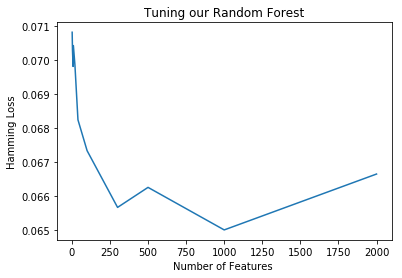

In [42]:
plt.plot(features_list, loss_list)
plt.ylabel("Hamming Loss")
plt.xlabel("Number of Features ")
plt.title("Tuning our Random Forest")


In [ ]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)